# Import Required Libraries

In [1]:
import sys

sys.path.insert(0, "../../src")
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from NSMBSS import *
from general_utils import *
from visualization_utils import *

import warnings

warnings.filterwarnings("ignore")

notebook_name = "Nonnegative_Antisparse_Copula"

# Source Generation and Mixing Scenario

In [2]:
rho = 0.0
N = 100000
NumberofSources = 5
NumberofMixtures = 10

SNR = 30  # dB

S = generate_correlated_copula_sources(
    rho=rho,
    df=4,
    n_sources=NumberofSources,
    size_sources=N,
    decreasing_correlation=False,
)

A = np.random.standard_normal(size=(NumberofMixtures, NumberofSources))
X = A @ S

X, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.97712621933108


# Visualize Generated Sources and Mixtures

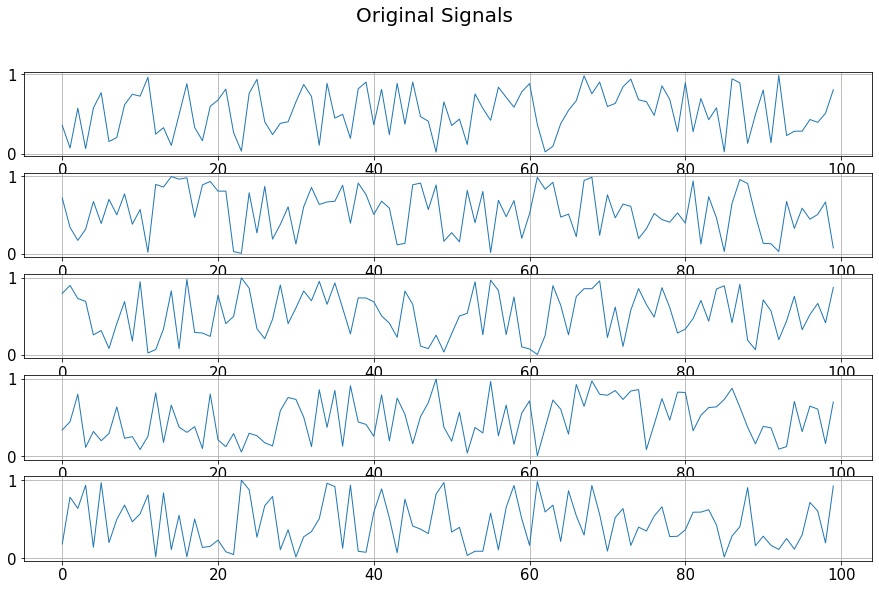

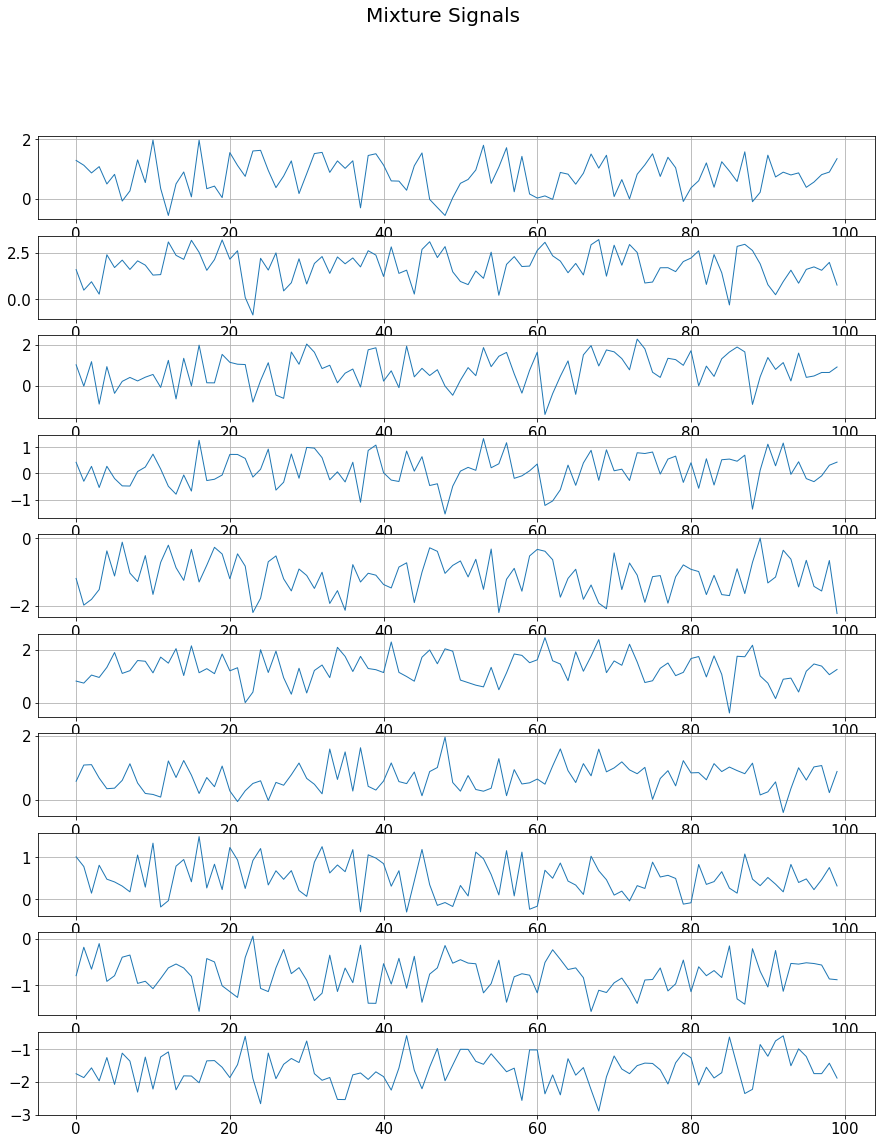

In [3]:
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    X[:, 0:100], title="Mixture Signals", figsize=(15, 18), colorcode=None
)

# Algorithm Hyperparameter Selection and Weight Initialization

In [4]:
model = OnlineNSM(
    s_dim=NumberofSources, x_dim=NumberofMixtures, set_ground_truth=True, S=S, A=A
)

# Run NSM Algorithm on Mixture Signals

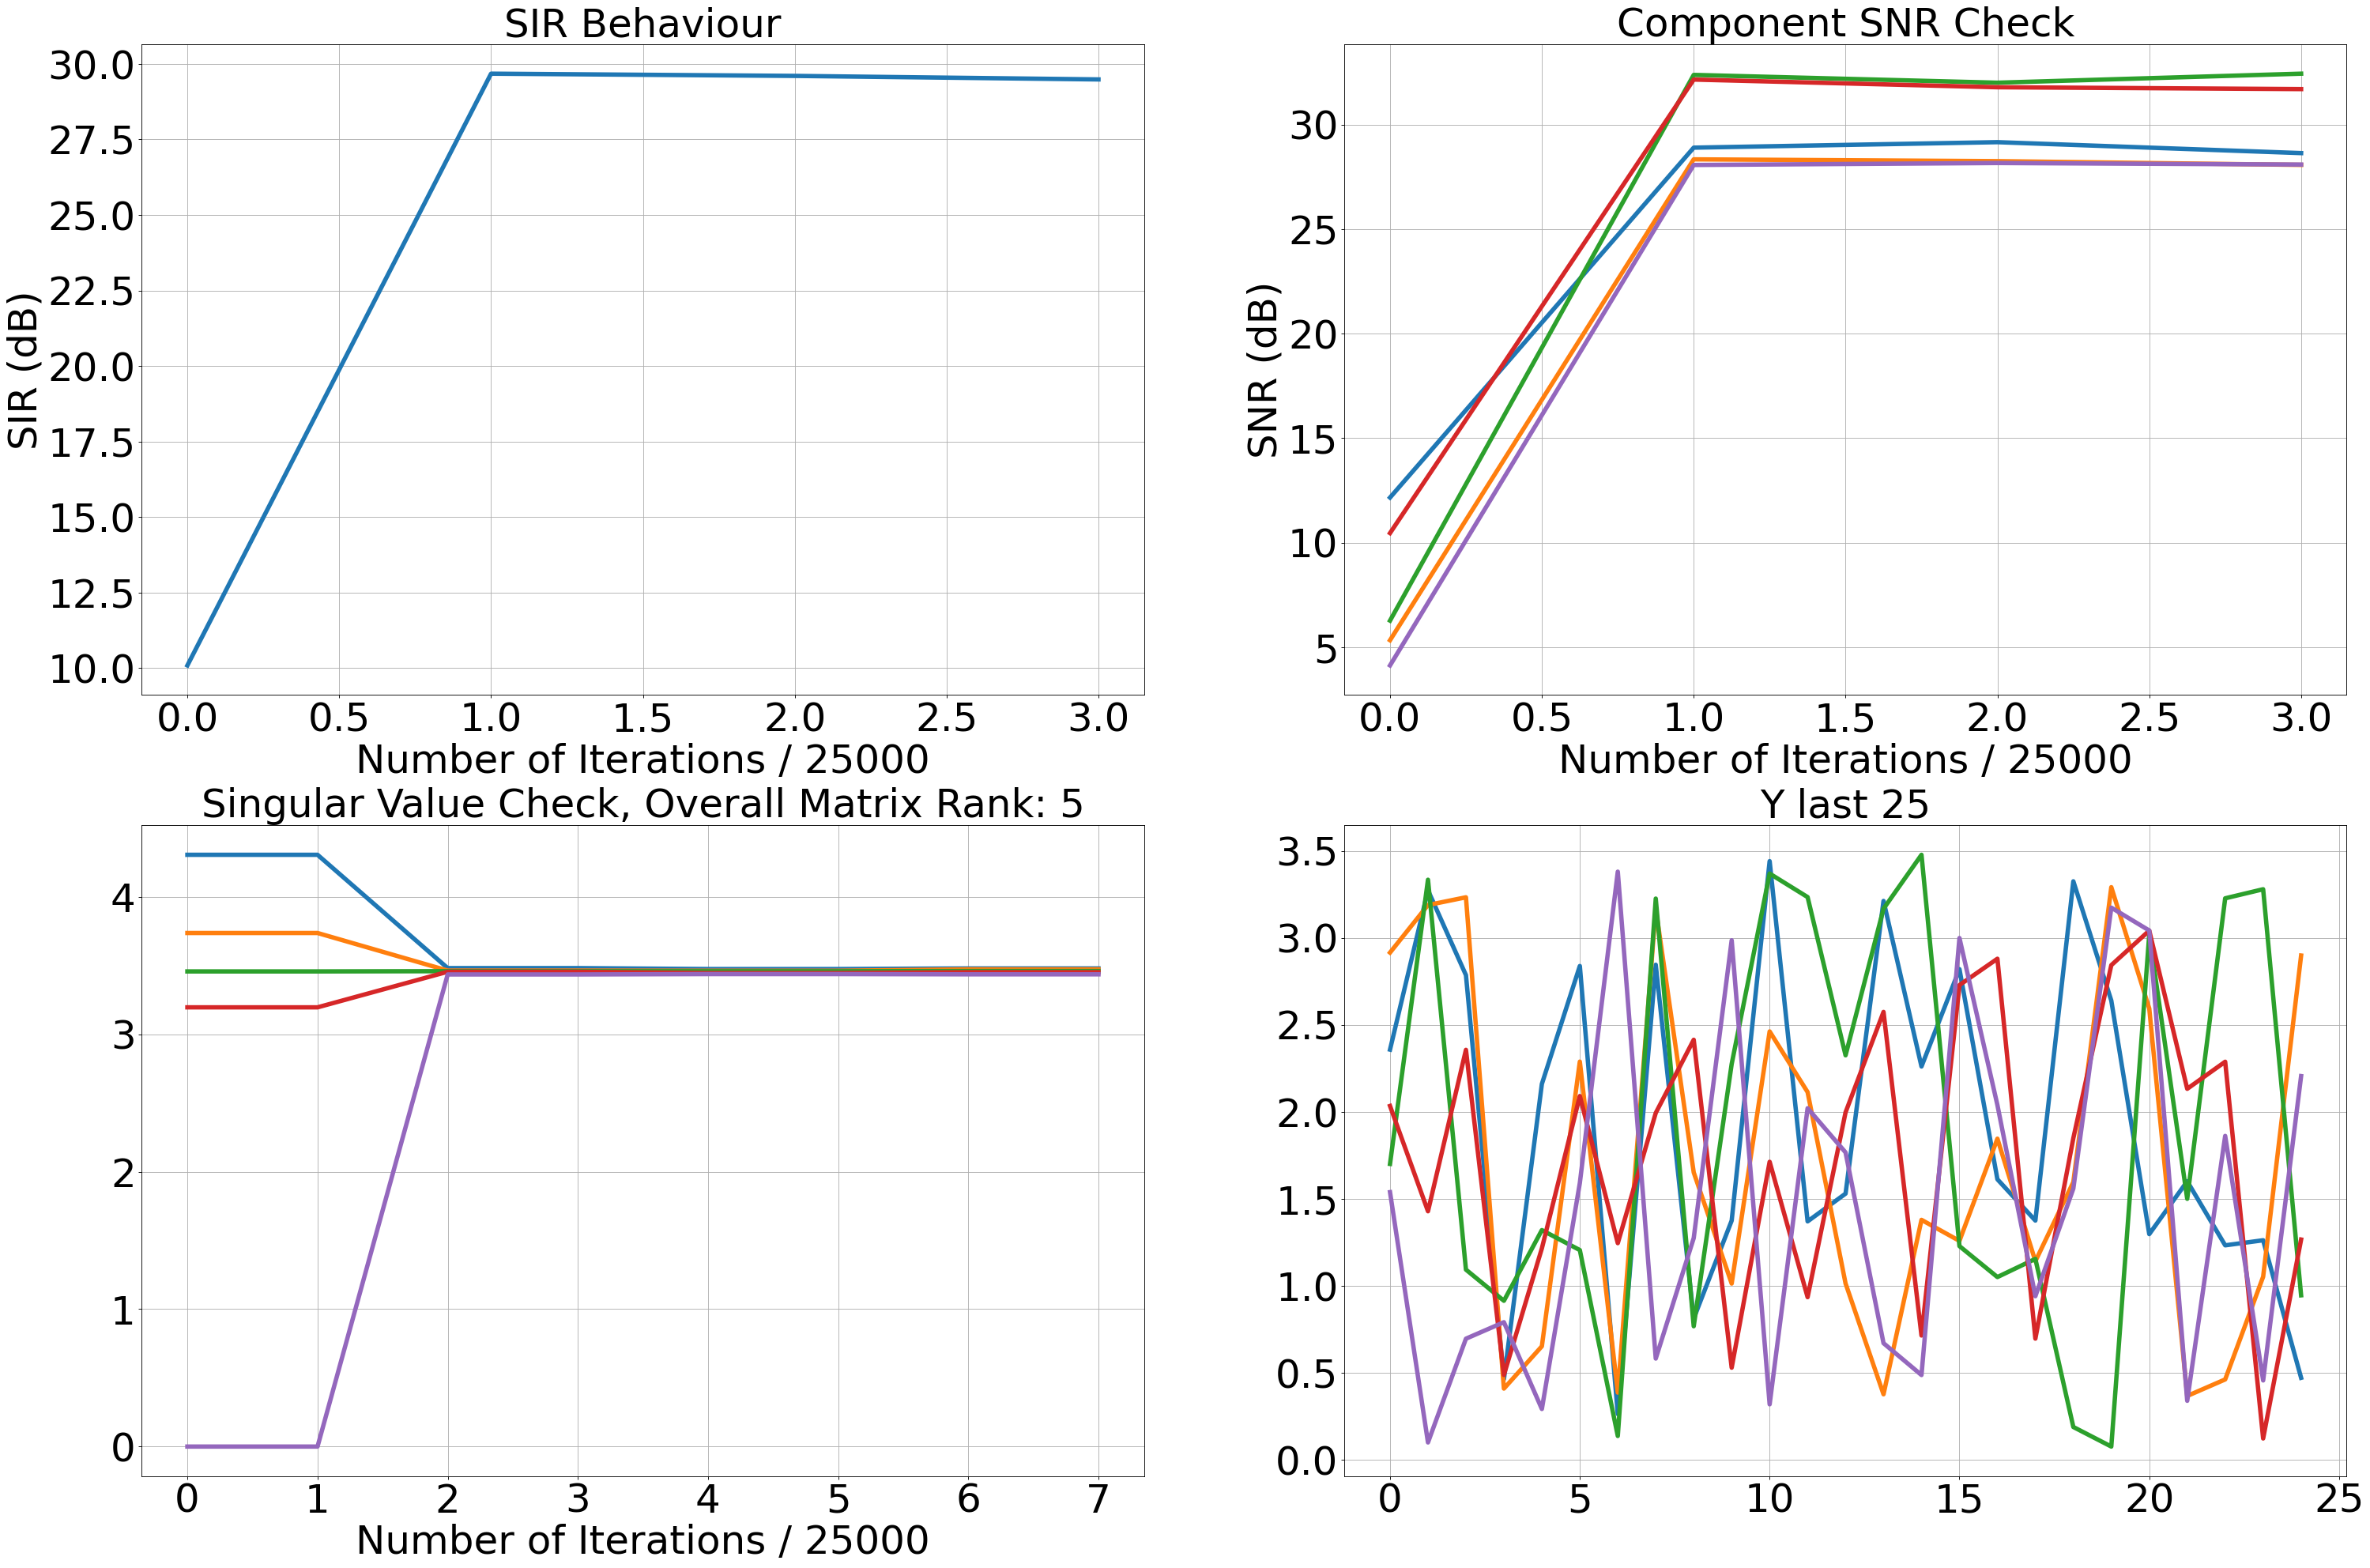

100%|██████████| 100000/100000 [00:50<00:00, 1989.80it/s]


Algorithm took 50.397210 sec.


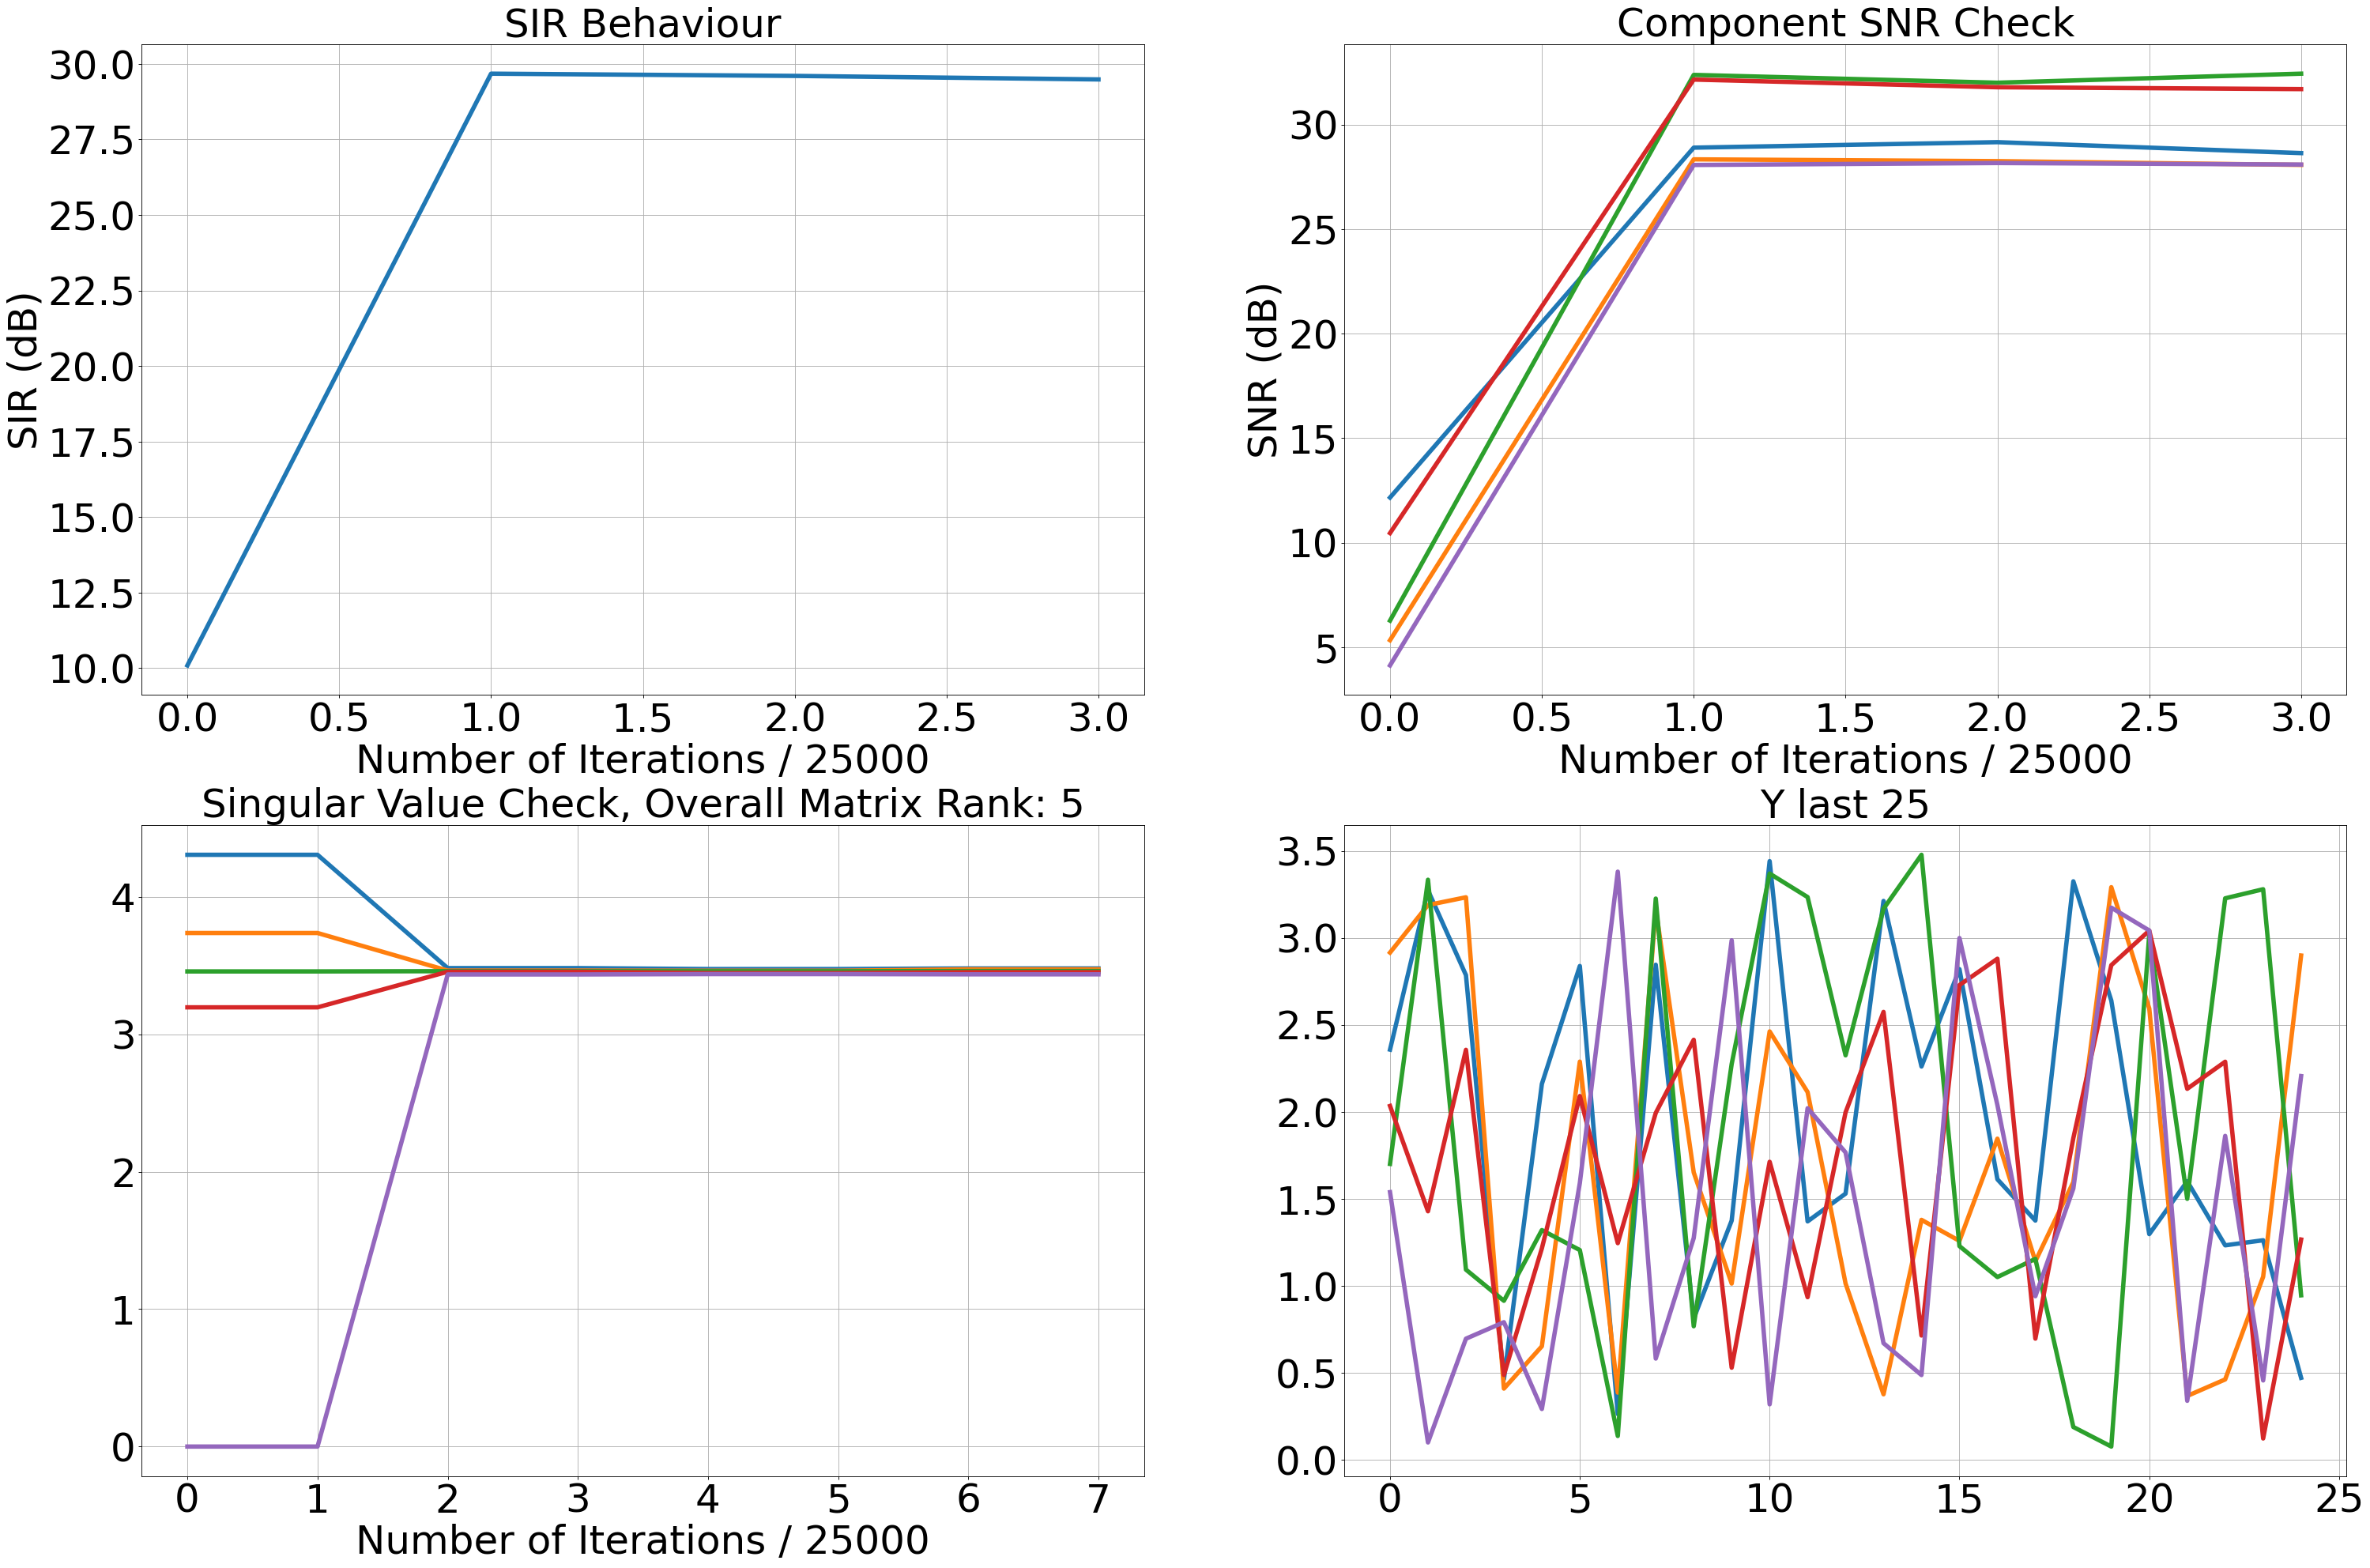

In [5]:
debug_iteration_point = 25000
with Timer() as t:
    model.fit_batch_nsm(
        X=X, debug_iteration_point=debug_iteration_point, plot_in_jupyter=True
    )

print("Algorithm took %f sec." % (t.interval))

# Calculate Resulting Component SNRs and Overall SINR

In [6]:
Wf = model.compute_overall_mapping(return_mapping=True)
# Wf = np.linalg.pinv(M * D.T) @ W @ model.Wpre
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10 * np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [28.91784241 28.30597989 31.99904551 32.26382999 28.32644756]

Overall SINR : 29.67240493410265


In [7]:
CalculateSIR(A, Wf)

(36.091894723028744, 5)

# Vizualize Extracted Signals Compared to Original Sources

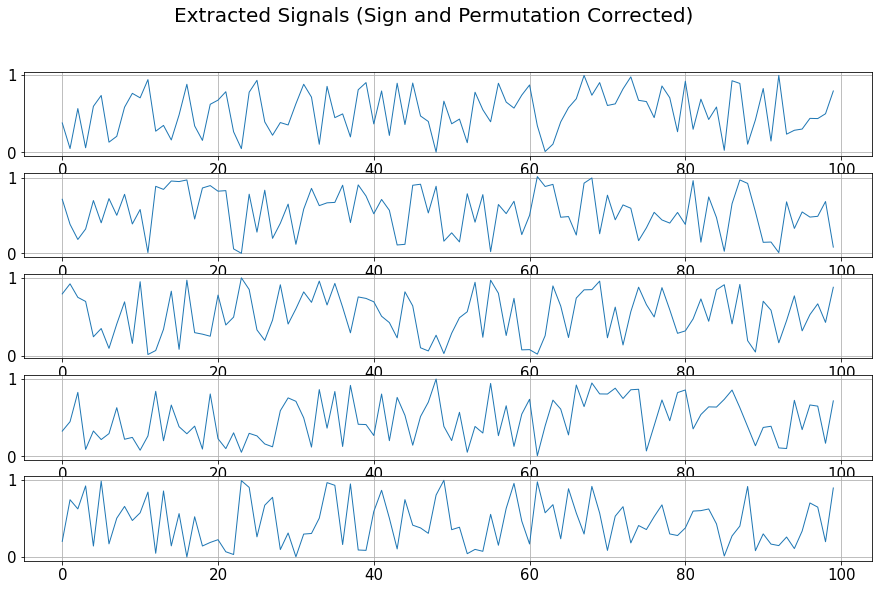

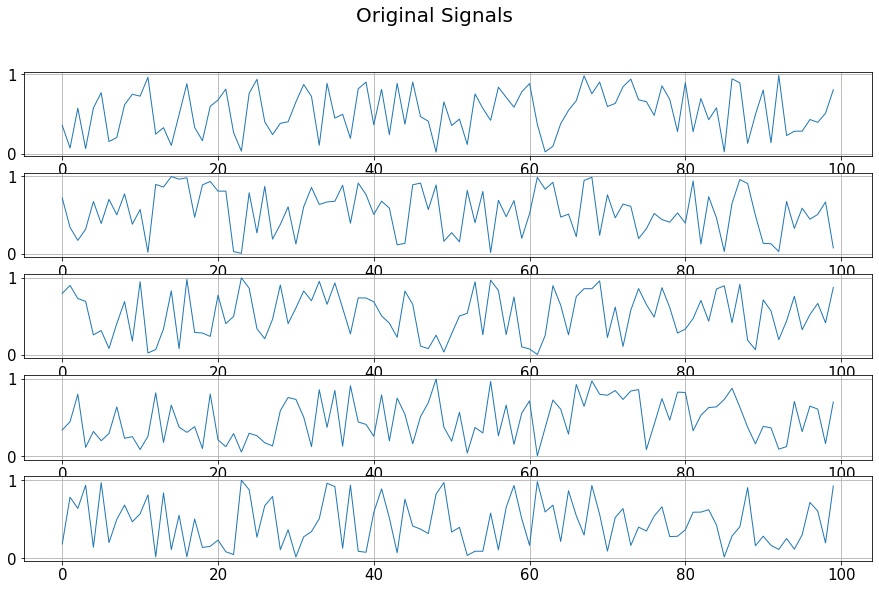

In [8]:
subplot_1D_signals(
    Y_[:, 0:100],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
    colorcode=None,
)
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)